# Transfer Learning to classify a Dog or a Cat

Let's use a deep convolutional neural network (DCNN) to predict images of dogs or cats. The "Transfer Learning" technique is to reuse an existing DCNN as feature extraction along with its trained weights for solving a problem in a slightly different domain. 

Deep convolutional networks exploit the hierachical distributed feature representations where lower levels of layers contain more generic features (edges and blobs) while the higher levels of layers extract information relevant to the application of the NN. 

This is based on the tutorial here:  [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

Keras [tensorflow] documentation: https://keras.io/layers/core/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools, functools
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K

import tf_threads
tfconfig = tf_threads.limit(tf, 2)
session = tf.Session(config=tfconfig)
K.set_session(session)

import h5py
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Reshape, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


# Load dataset

Directory structure for this dataset:
~~~
DogsCats/
    train/
        cat.001.jpg
        cat.002.jpg
        dog.001.jpg
        dog.002.jpg
~~~


In [3]:
DATASET = lambda fname = '': os.path.join('datsets/transfer_learning/DogsCats', fname)
assert os.path.exists(DATASET())

plt.figure()

print("Showing the train/cat.100.jpg, full path : {}".format(
            DATASET('train/cat.100.jpg')
        )
     )

Showing the train/cat.100.jpg, full path : /dsa/data/all_datasets/transfer_learning/DogsCats/train/cat.100.jpg


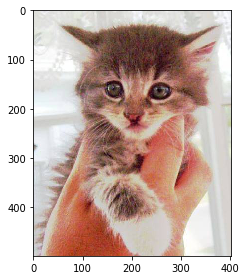

In [44]:
imshow(imread(DATASET('train/cat.100.jpg')))

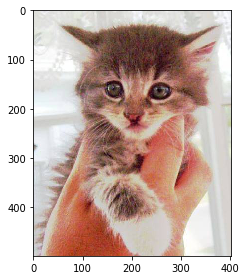

In [45]:
imshow(imread(DATASET("train/cat.100.jpg")))

In [46]:
help(imshow)

Help on function imshow in module skimage.io._io:

imshow(arr, plugin=None, **plugin_args)
    Display an image.
    
    Parameters
    ----------
    arr : ndarray or str
        Image data or name of image file.
    plugin : str
        Name of plugin to use.  By default, the different plugins are
        tried (starting with the Python Imaging Library) until a suitable
        candidate is found.
    
    Other parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.



In [47]:
help(imread)

Help on function imread in module skimage.io._io:

imread(fname, as_grey=False, plugin=None, flatten=None, **plugin_args)
    Load an image from file.
    
    Parameters
    ----------
    fname : string
        Image file name, e.g. ``test.jpg`` or URL.
    as_grey : bool
        If True, convert color images to grey-scale (64-bit floats).
        Images that are already in grey-scale format are not converted.
    plugin : str
        Name of plugin to use.  By default, the different plugins are
        tried (starting with the Python Imaging Library) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    
    Other Parameters
    ----------------
    flatten : bool
        Backward compatible keyword, superseded by `as_grey`.
    
    Returns
    -------
    img_array : ndarray
        The different colour bands/channels are stored in the
        third dimension, such that a grey-image is MxN, an
        RGB

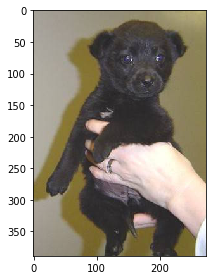

In [48]:
filename = DATASET("train/dog.200.jpg")
imshow(imread(filename))

# Creating a DCNN model based on VGG16

We'll create a computational graph based on VGG Networks (http://www.robots.ox.ac.uk/~vgg/research/very_deep/). We'll transfer VGG network along with its weights instead of creating the neural network from scratch. But we'll detach dense layers from VGG16 network and add our own. During training, all the weights within VGG16 will stay locked so we'll only be using whatever features VGG16 gives us. Only the weights in the dense layers will be trained and this part serves as the classifier. 

In [50]:
images = Input(shape = (150, 150, 3))

vgg16 = VGG16(weights='imagenet', include_top=False)

# Lock the VGG16 Layers
for layer in vgg16.layers:
    layer.trainable = False 
    
classifier = [
    Flatten(input_shape = vgg16.output_shape[1:]),
    
    # Size, and Neuron Type
    Dense(256, activation="relu", name = 'dense_1'),
    Dropout(0.5),

    # Size, and Neuron Type
    Dense(1, activation="sigmoid", name = 'dense_2'),
]

y_pred = functools.reduce(lambda f1, f2: f2(f1), [images, vgg16]+classifier)

model = Model(inputs = [images], outputs = [y_pred])

In [51]:
model.compile(loss="binary_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
________________________________________________________

# Training a DCNN model using transfer learning

Now we are going to create generators that generate batches

In [53]:
BATCH_SIZE = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [54]:
train_generator = train_datagen.flow_from_directory(
    DATASET('TransferLearning/train'),
    target_size= (150, 150),
    batch_size = BATCH_SIZE,
    class_mode= "binary")

validation_generator = test_datagen.flow_from_directory(
    DATASET('TransferLearning/validation'),
    target_size=(150, 150),
    batch_size = BATCH_SIZE,
    class_mode = "binary")

Found 24200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [25]:
try:
    model.fit_generator(
        train_generator, steps_per_epoch = 12500 // BATCH_SIZE,
        validation_data=validation_generator, validation_steps=800 // BATCH_SIZE,
        epochs=1) # Normally a few more epochs will be expected.
except KeyboardInterrupt:
    """Kernal -> Interrupt"""

Epoch 1/1
625/625 [==============================] - 6718s - loss: 0.5320 - acc: 0.7352 - val_loss: 0.3769 - val_acc: 0.8575


In [26]:
model.save_weights('./weights_dogs_cats.h5')
os.path.exists('./weights_dogs_cats.h5')

True

# Evaluating the model

Let's define a class to allow us to reuse this model. 

In [2]:
class DogsVsCats(Model):
    def __init__(self): 
        self.images = Input(shape = (150, 150, 3))
        self.vgg16 = VGG16(weights = "imagenet", include_top = False)
        
        classifier = [
            Flatten(input_shape = self.vgg16.output_shape[1:]),
            Dense(256, activation = "relu", name = "dense_1"),
            Dropout(0.5),
            Dense(1, activation = "sigmoid", name = "dense_2")
        ]

        self.prediction = functools.reduce(lambda f1, f2: f2(f1), [self.images, self.vgg16]+classifier)
        
        super(DogsVsCats, self).__init__(
            inputs = [self.images],
            outputs = [self.prediction]
        )
        
        self.compile(loss = "binary_crossentropy", 
                    optimizer = SGD(lr = 0.0001, momentum = 0.9), 
                    metrics = ["accuracy"])
        
    def freeze_vgg16(trainable = False):
        for layer in self.vgg16.layers:
            layer.trainable = trainable

In [56]:
new_model = DogsVsCats()
new_model.load_weights("./weights_dogs_cats.h5")

In [57]:
loss, accuracy = new_model.evaluate_generator(validation_generator, steps = 800 // BATCH_SIZE)
print('loss:', loss, 'accuracy:', accuracy)

loss: 0.376882101223 accuracy: 0.857500006258


Cat


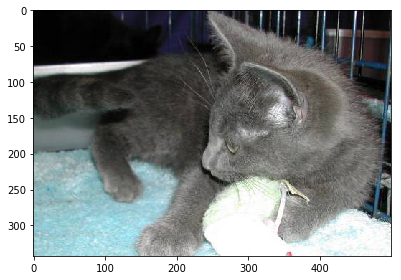

In [81]:
im_test = imread(DATASET('test1/100.jpg'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = new_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Cat', 'Dog'][y_pred>=0.5])

## Using a pretrained weight set

In [4]:
assert os.path.exists('/dsa/data/all_datasets/transfer_learning/DogsCats/weights_dogs_cats.h5')

pretrained_model = DogsVsCats()
pretrained_model.load_weights("/dsa/data/all_datasets/transfer_learning/DogsCats/weights_dogs_cats.h5")

#### Evaluate accuracy of this model.

In [ ]:
loss, accuracy = pretrained_model.evaluate_generator(validation_generator, steps = 800)
print("loss:", loss, "accuracy:", accuracy)

loss: 0.18830800442 accuracy: 0.913624994233


CAT


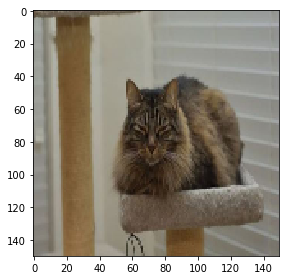

In [15]:
pepper_pic = "fan1.JPG"

im_test = imread(pepper_pic)
im_test = resize(im_test, (150, 150), mode = "reflect")
imshow(im_test)
y_pred = pretrained_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(["CAT", "DOG"][y_pred >= 0.5])

IT'S A DOGGO


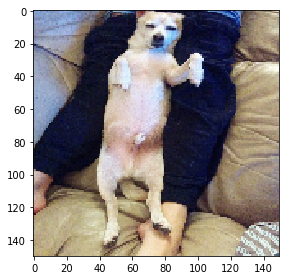

In [11]:
weight_source = '/dsa/data/all_datasets/transfer_learning/DogsCats/weights_dogs_cats.h5'
pic_source = "PEPPER6.jpg"
model = DogsVsCats()
model.load_weights(weight_source)
image_test = imread(pic_source)
image_test = resize(image_test, (150, 150), mode = "reflect")
imshow(image_test)
y_pred = model.predict(np.expand_dims(image_test, 0)).squeeze()
print(["IT'S A CAT", "IT'S A DOGGO"][y_pred >= 0.50])